# Introduction to value-based DRL

In [1]:
!nvidia-smi

Wed Aug 10 20:49:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   54C    P8    25W / 220W |   1616MiB /  8192MiB |     64%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from IPython.display import Video
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 60
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('.', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
torch.cuda.is_available()

True

In [5]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, record=False, unwrapped=False ,
                    inner_wrappers=None, outer_wrappers=None):
        mdir = tempfile.mkdtemp()
        
        env = gym.make(env_name)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)

        if record:
            env = gym.wrappers.RecordVideo(env, f"videos/{gym.__version__}")


        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [6]:
def get_videos_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [7]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '7',
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm',
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert',
                 '-coalesce',
                 '-delay', '7',
                 '-loop', '0',
                 '-fuzz', '2%',
                 '+dither',
                 '-deconstruct',
                 '-layers', 'Optimize',
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        sufix = str(meta['episode_id'] if subtitle_eps is None \
                    else subtitle_eps[meta['episode_id']])
        strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
    return strm

In [8]:
class DiscountedCartPole(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def step(self, a):
        o, r, d, _ = self.env.step(a)
        (x, x_dot, theta, theta_dot) = o
        pole_fell =  x < -self.env.unwrapped.x_threshold \
                    or x > self.env.unwrapped.x_threshold \
                    or theta < -self.env.unwrapped.theta_threshold_radians \
                    or theta > self.env.unwrapped.theta_threshold_radians
        r = -1 if pole_fell else 0
        return o, r, d, _

## NFQ: The first attempt at value-based DRL

### Selecting a value function to approximate
Estimate action-value function $Q(s, a; \theta)$ ($\theta$ are the wieghts of a nn)


### Selecting what to optimize
An ideal objective in value-based DRL is to minimize the loss with respect to the optimal action-value function $q*$

$L_i(\theta_i) = \mathbb{E}_{s,a} \Big[ (q_*(s , a) - Q(s, a; \theta_i) )^2\Big]$

The optimal action-value function

$q_*(s,a) = \max_{\pi} \mathbb{E}_{\pi} \Big[ G_t \rvert S_t = s,\ A_t = a \Big],\ \forall s \in S,\ \forall a \in A(s)$


### Selecting the targets for policy evaluation

There are multiple ways to evaluate a policy. The core targets are the MC target, the TD target, the n-step target, and lambda target. In this implementation, the TD target will be used


### Selections for the NFQ algorithm
* Approxiamte the action-value funciton $Q(s, a; \theta)$
* Use a state-in-values-out architecture (nodes: 4, 512, 128, 2)
* Optimize the action-value function to approximate the optimal action-value function $q*(s, a)$
* Use off-policy TD targets $(r + \gamma * \max_{a'} Q(s', a'; \theta))$ to evaluate policies
* Use an epsilon-greedy strategy (epsilon set to 0.5) to improve policies
* Use mean squared error (MSE) for the loss function
* Use RMSprop as the optimizer with a lr of $0.0005$

### NFQ has three main steps:
1. Collect $E$ experiences: $(s, a, s', d)$ tuples. Use 1024 samples
2. Calculate the off-policy TD targets: $r + \gamma * \max_{a'} Q(s', a'; \theta)$
3. Fit the action-value function $Q(s, a; \theta)$ using MSE and RMSprop

The algorithm repeats steps 2 and 3 $k$ number of times before going back to step 1. That's what makes it fitted:
the nested loop. Use $k = 40$

In [9]:
class FCQ(nn.Module):

    def __init__(self,
                input_dim,
                output_dim,
                hidden_dims=(32, 32),
                activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1]
            )
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        device = 'cpu'
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
    
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                            device=self.device,
                            dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
    
    def forward(self, state):
        x = self._format(state)

        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        # torch.from_numpy creates a tensor from a np.array
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load(self, experiences):
        states, actions, rewards, new_states, is_terminals = experiences
        states = self.numpy_float_to_device(states)
        actions = torch.from_numpy(actions).long().to(self.device)
        rewards = self.numpy_float_to_device(rewards)
        new_states = self.numpy_float_to_device(new_states)
        is_terminals = self.numpy_float_to_device(is_terminals)
        return states, actions, rewards, new_states, is_terminals


In [10]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False
    
    def select_action(self, model, state):
        # so that torch doesn't calculate 
        # the gradient of the following
        # tensors/variables
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [11]:
class EGreedyStrategy():
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.exploratory_action_taken = None
    
    def select_action(self, model, state):
        self.exploratory_action_taken = False
        # so that torch doesn't calculate 
        # the gradient of the following
        # tensors/variables
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

            if np.random.rand() > self.epsilon:
                action = np.argmax(q_values)
            else:
                action = np.random.randint(len(q_values))
            
            self.exploratory_action_taken = action != np.argmax(q_values)
            return action

In [12]:
class NFQ():

    def __init__(self,
                value_model_fn,
                value_optimizer_fn,
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                batch_size,
                epochs):
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.batch_size = batch_size
        self.epochs = epochs
    
    def optimize_model(self, experiences):
        # get the experiences for later use
        states, actions, rewards, next_states, is_terminals = experiences
        
        # select max_a Q(s_{t+1}, a)
        max_a_q_sp = self.online_model(next_states).detach().max(1)[0].unsqueeze(1)
        # target
        target_q_s = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)
        # select Q(s_{t}, a)
        q_sa = self.online_model(states).gather(1, actions)

        td_errors = q_sa - target_q_s

        # MSE loss
        value_loss = td_errors.pow(2).mul(0.5).mean()
        # reset gradients
        self.value_optimizer.zero_grad()
        # calculate gradients of loss
        value_loss.backward()
        # optimize given the gradient calculated
        self.value_optimizer.step()
    
    def interaction_step(self, state, env):
        # use either E-greedy or just greedy with the online model
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = env.step(action)
        # check if the environement has reached maximum steps
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        # if env has reached maximum steps
        # then it shouldn't cancel the reward
        # when calculating the TD target
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        # stats
        self.experiences.append(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def train(self, make_env_fn, make_env_kargs, seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
        
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma

        # setting up env and random seeds
        env = self.make_env_fn(**self.make_env_kargs)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []

        self.online_model = self.value_model_fn(nS, nA)
        self.value_optimizer = self.value_optimizer_fn(self.online_model, self.value_optimizer_lr)

        self.training_strategy = self.training_strategy_fn()
        self.evaluation_strategy = self.evaluation_strategy_fn()
        self.experiences = []

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()

            # reset data
            state, is_terminal = env.reset(seed=self.seed), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for _ in count():
                # select action, take it, and save data/experience
                state, is_terminal = self.interaction_step(state, env)

                # update the model when enough experiences
                if len(self.experiences) >= self.batch_size:
                    experiences = np.array(self.experiences)
                    batches = [np.vstack(sars) for sars in experiences.T]
                    # load experiences onto torch/device
                    experiences = self.online_model.load(batches)
                    # optimize the model with the collected experiences
                    for _ in range(self.epochs):
                        self.optimize_model(experiences)
                    
                    self.experiences.clear()

                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            self.save_checkpoint(episode-1, self.online_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)

            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])

            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:]) / np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)

            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                        mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes*60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                                reached_max_episodes or \
                                reached_goal_mean_reward
            
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score
            )
            print(debug_message, end='\r', flush=True)

            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
        
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close()
    
        del env
        return result, final_eval_score, training_time, wallclock_time
    

    # evaulates the model for n_episodes
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1, seed=None):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(seed=seed), False
            rs.append(0)

            for i in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
            
        return np.mean(rs), np.std(rs)
    
    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try:
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}
        
        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]): path for path in paths}
        last_ep = max(paths_dic.keys())

        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)
        
        return self.checkpoint_paths
    
    def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos,
                            title=title.format(self.__class__.__nam__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)
    
    def demo_progression(self, title='{} Agent progression', max_n_videos=5):
        env = self.make_env_fn(**self.make_env_kargs, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)
    
    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(),
                    os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [14]:
nfq_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    # value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
    # evaluation_strategy_fn = lambda: EGreedyStrategy(epsilon=0.05)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    batch_size = 1024
    epochs = 40

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = NFQ(value_model_fn, 
                value_optimizer_fn, 
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                batch_size,
                epochs)

    # make_env_fn, make_env_kargs = get_make_env_fn(
    #     env_name=env_name, addon_wrappers=[DiscountedCartPole,])
    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    nfq_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
nfq_results = np.array(nfq_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 000017, ar 10 017.0±000.0, 100 017.0±000.0, ex 100 0.4±0.0, ev 009.0±000.0
el 00:01:00, ep 0736, ts 015563, ar 10 030.3±007.1, 100 030.9±014.4, ex 100 0.3±0.1, ev 032.4±009.8
el 00:02:00, ep 1377, ts 037067, ar 10 045.7±023.5, 100 034.0±020.3, ex 100 0.3±0.1, ev 080.1±039.7
el 00:03:00, ep 1879, ts 061572, ar 10 054.2±024.2, 100 054.3±034.1, ex 100 0.3±0.1, ev 102.8±013.7
el 00:04:00, ep 2277, ts 093731, ar 10 089.6±072.2, 100 095.9±046.9, ex 100 0.3±0.1, ev 173.2±067.0
el 00:05:00, ep 2541, ts 128458, ar 10 131.7±084.7, 100 149.7±110.6, ex 100 0.3±0.1, ev 395.5±096.4
el 00:06:00, ep 2756, ts 163801, ar 10 193.0±122.4, 100 156.8±113.7, ex 100 0.3±0.1, ev 365.7±124.2
el 00:07:00, ep 2981, ts 199764, ar 10 243.3±142.8, 100 171.2±122.7, ex 100 0.3±0.1, ev 441.0±070.8
el 00:08:01, ep 3194, ts 236073, ar 10 158.3±066.1, 100 161.5±101.7, ex 100 0.3±0.0, ev 439.5±090.4
el 00:09:01, ep 3416, ts 275476, ar 10 226.9±115.3, 100 182.9±117.3, ex 100 0.3±0.1, ev 440.5±085.1


In [20]:
nfq_max_t, nfq_max_r, nfq_max_s, \
    nfq_max_sec, nfq_max_rt = np.max(nfq_results, axis=0).T
nfq_min_t, nfq_min_r, nfq_min_s, \
    nfq_min_sec, nfq_min_rt = np.min(nfq_results, axis=0).T
nfq_mean_t, nfq_mean_r, nfq_mean_s, \
    nfq_mean_sec, nfq_mean_rt = np.mean(nfq_results, axis=0).T
nfq_x = np.arange(len(nfq_mean_s))

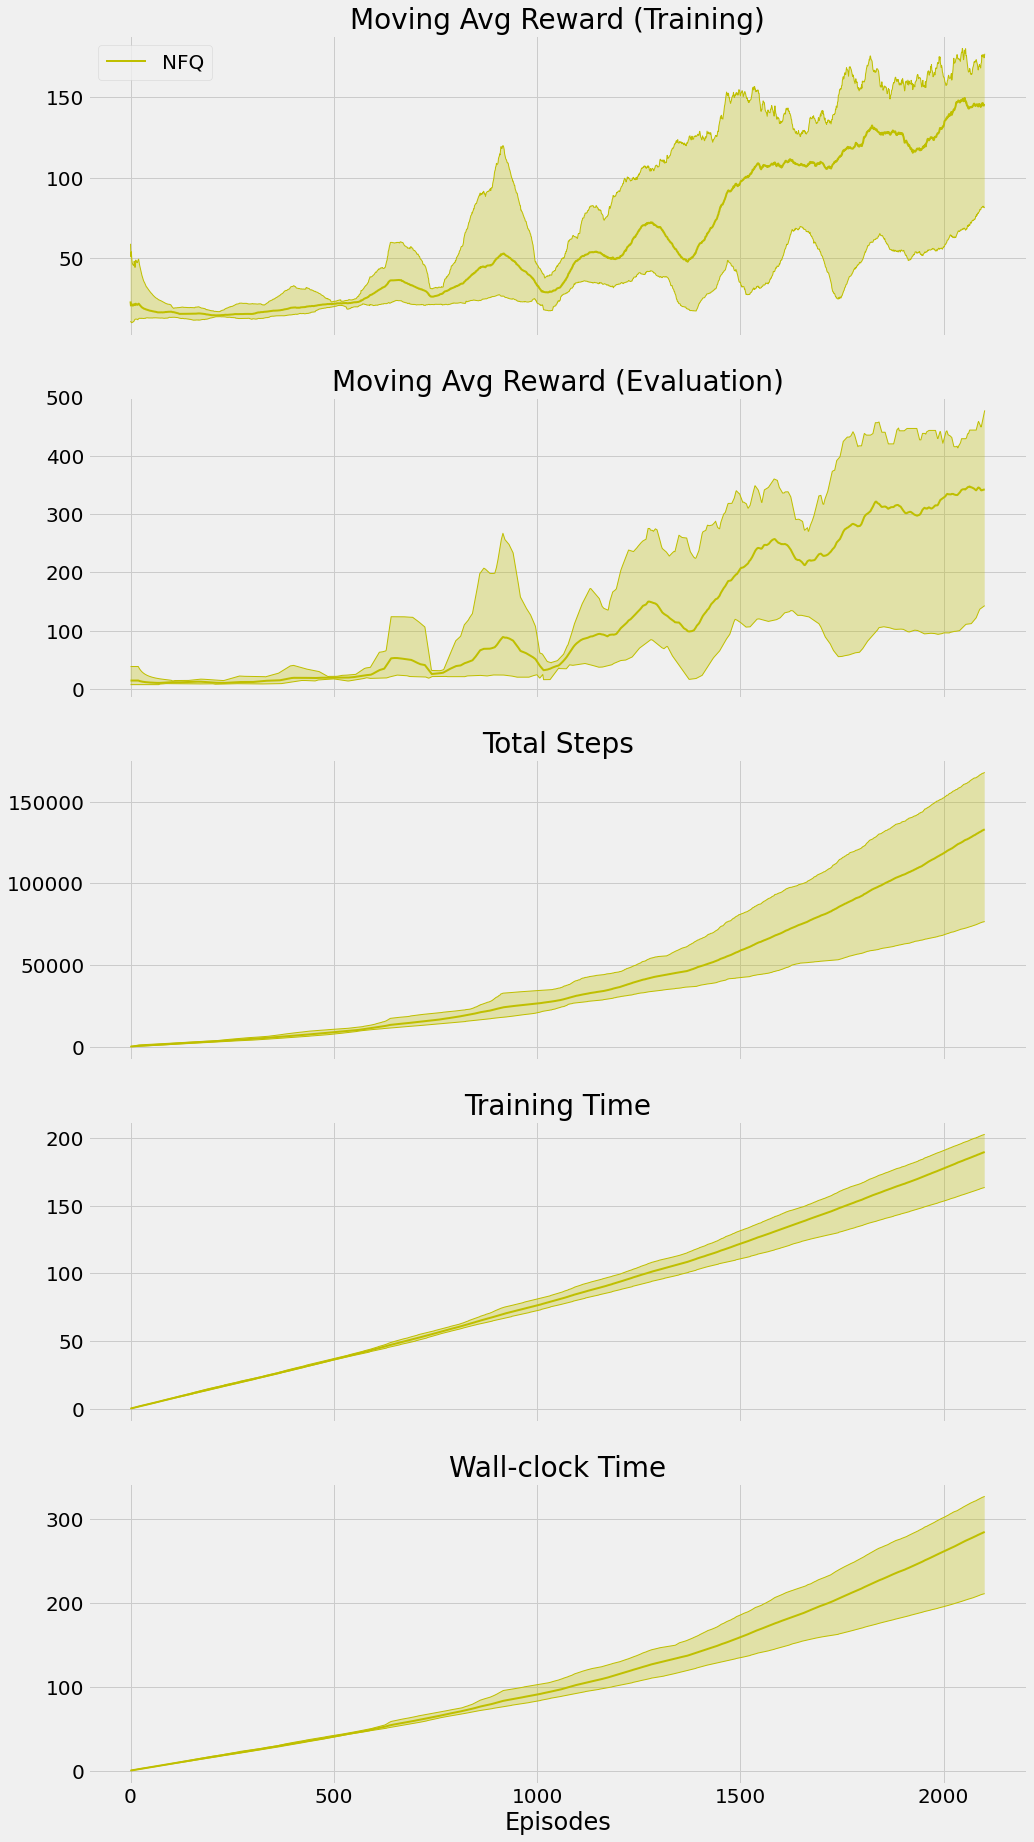

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [23]:
nfq_root_dir = os.path.join(RESULTS_DIR, 'nfq')
not os.path.exists(nfq_root_dir) and os.makedirs(nfq_root_dir)

np.save(os.path.join(nfq_root_dir, 'x'), nfq_x)

np.save(os.path.join(nfq_root_dir, 'max_r'), nfq_max_r)
np.save(os.path.join(nfq_root_dir, 'min_r'), nfq_min_r)
np.save(os.path.join(nfq_root_dir, 'mean_r'), nfq_mean_r)

np.save(os.path.join(nfq_root_dir, 'max_s'), nfq_max_s)
np.save(os.path.join(nfq_root_dir, 'min_s'), nfq_min_s )
np.save(os.path.join(nfq_root_dir, 'mean_s'), nfq_mean_s)

np.save(os.path.join(nfq_root_dir, 'max_t'), nfq_max_t)
np.save(os.path.join(nfq_root_dir, 'min_t'), nfq_min_t)
np.save(os.path.join(nfq_root_dir, 'mean_t'), nfq_mean_t)

np.save(os.path.join(nfq_root_dir, 'max_sec'), nfq_max_sec)
np.save(os.path.join(nfq_root_dir, 'min_sec'), nfq_min_sec)
np.save(os.path.join(nfq_root_dir, 'mean_sec'), nfq_mean_sec)

np.save(os.path.join(nfq_root_dir, 'max_rt'), nfq_max_rt)
np.save(os.path.join(nfq_root_dir, 'min_rt'), nfq_min_rt)
np.save(os.path.join(nfq_root_dir, 'mean_rt'), nfq_mean_rt)